# The project architecture was created with cookiecutter

In [1]:
#cookiecutter https://github.com/drivendata/cookiecutter-data-science.git

# Download the dataset

In [2]:
#!cd ../data/raw

In [3]:
#!pwd
#!kaggle datasets download -d borismarjanovic/price-volume-data-for-all-us-stocks-etfs -p ../data/raw

In [4]:
#%cd ../../notebooks
#%cd ../data/raw
#!ls
#!unzip price-volume-data-for-all-us-stocks-etfs.zip 
#!ls
#%cd ../../notebooks

In [5]:
!pip install --upgrade pip
!pip3 install plotly

Requirement already up-to-date: pip in /Users/mildo/anaconda3/lib/python3.7/site-packages (19.3.1)


In [6]:
%matplotlib inline

# Load dataset 

In [351]:
import os
def load_raw_dataset(product, index_column, underlyer='aapl.us.txt'):
    raw_data_path = os.path.join(os.path.pardir, 'data', 'raw', product)
    data_path = os.path.join(raw_data_path, underlyer)
    print('Opening file ', data_path)
    return pd.read_csv(data_path)

# Process Data - Generate feature vector

In [352]:
import pandas as pd


def prepare_feture_vector(df):
    # Feature vector

    df_tomorrow = generate_tomorrow_dataset(df)
    df_yesterday = generate_yesterday_dataset(df)
    # concatenate yesterday - today and tomorrow
    df = pd.concat([df_yesterday, df, df_tomorrow], axis=1, sort=False)

    # eliminate nan values from before yesterday and after tomorrow
    df = df[1:-2]

    return (df
            .assign(Date=lambda x: pd.to_datetime(x.Date))
            .assign(Average_High_Low=lambda x: (x.High + x.Low) / 2)
            .assign(Average_Day=lambda x: (x.Open + x.Close) / 2)
            .assign(Diff_Close_Open=lambda x: (x.Close - x.Open) / x.Open)
            .assign(Diff_Tomorrow_Open=lambda x: (x.Tomorrow_Open - x.Open) / x.Open)
            .assign(Label=lambda x: np.where(((x.Tomorrow_Open - x.Open) > 0), 1, 0))
            .assign(Diff_Today_Open=lambda x: (x.Open - x.Yesterday_Open) / x.Yesterday_Open)
            .assign(Diff_Today_Close=lambda x: (x.Close - x.Yesterday_Close) / x.Yesterday_Close)
            .assign(Diff_Today_Volume=lambda x: (x.Volume - x.Yesterday_Volume) / x.Yesterday_Volume)
            .assign(Diff_Today_High=lambda x: (x.High - x.Yesterday_High) / x.Yesterday_High)
            .assign(Diff_Today_Low=lambda x: (x.Low - x.Yesterday_Low) / x.Yesterday_Low)
            )


def generate_tomorrow_dataset(today_dataset):
    df_tomorrow = today_dataset[['Date', 'Open']].copy()
    df_tomorrow = df_tomorrow[1:]
    df_tomorrow.columns = ['Tomorrow_Date', 'Tomorrow_Open']
    df_tomorrow['aux_index'] = df_tomorrow.index - 1
    df_tomorrow.set_index('aux_index', inplace=True, drop=True)

    return df_tomorrow


def generate_yesterday_dataset(today_dataset):
    df_yesterday = today_dataset[['Date', 'Open', 'Close', 'Volume', 'Low', 'High']].copy()
    df_yesterday.columns = ['Yesterday_Date', 'Yesterday_Open', 'Yesterday_Close', 'Yesterday_Volume', 
                            'Yesterday_Low',
                            'Yesterday_High']
    df_yesterday['aux_index'] = df_yesterday.index + 1
    df_yesterday.set_index('aux_index', inplace=True, drop=True)

    return df_yesterday



# Write processed data - Dataset with feature vector

In [353]:
def process_dataset(product='Stocks', underlyer='aapl.us.txt'):
    dataset = load_raw_dataset(product, underlyer)
    dataset = prepare_feture_vector(dataset)
    write_data(dataset)
    return dataset


def write_data(dataset):
    processed_data_path = os.path.join(os.path.pardir, 'data', 'processed')
    dataset_path = os.path.join(processed_data_path, 'dataset.csv')
    dataset.to_csv(dataset_path)
    
def generate_train_dataset(dataset, split_date='2016-01-01'):
    return dataset[(dataset.Date < split_date) & (dataset.Date > '2013-01-01')]


def generate_test_dataset(dataset, split_date='2016-01-01'):
    #    columns = [column for column in df.columns if column != 'Survived']
    # df[df.Survived == -888][columns]
    return dataset[dataset.Date > split_date]

df= process_dataset()


Opening file  ../data/raw/Stocks/aapl.us.txt


# Explore data - Visualizations 

In [354]:
df[['Open','Tomorrow_Open','Label']].head()

,Open,Tomorrow_Open,Label
1,0.42388,0.42516,1
2,0.42516,0.42902,1
3,0.42902,0.43927,1
4,0.43927,0.44052,1
5,0.44052,0.45718,1


In [355]:
df.describe(include="all")


,Yesterday_Date,Yesterday_Open,Yesterday_Close,Yesterday_Volume,Yesterday_Low,Yesterday_High,Date,Open,High,Low,...,Average_High_Low,Average_Day,Diff_Close_Open,Diff_Tomorrow_Open,Label,Diff_Today_Open,Diff_Today_Close,Diff_Today_Volume,Diff_Today_High,Diff_Today_Low
count,8362,8362.000000,8362.000000,8.362000e+03,8362.000000,8362.000000,8362,8362.000000,8362.000000,8362.000000,...,8362.000000,8362.000000,8362.000000,8362.000000,8362.000000,8362.000000,8362.000000,8362.000000,8362.000000,8362.000000
unique,8362,NaN,NaN,NaN,NaN,NaN,8362,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,2015-02-24,NaN,NaN,NaN,NaN,NaN,1989-12-27 00:00:00,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,1,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
first,NaN,NaN,NaN,NaN,NaN,NaN,1984-09-10 00:00:00,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,NaN,NaN,NaN,NaN,NaN,NaN,2017-11-09 00:00:00,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,22.247873,22.244501,1.066606e+08,22.018047,22.459291,NaN,22.268688,22.480222,22.038628,...,22.259425,22.267048,-0.000168,0.001140,0.494499,0.001140,0.001131,inf,0.001041,0.001090
std,NaN,37.694171,37.695077,9.935617e+07,37.378675,37.988710,NaN,37.730159,38.024774,37.414145,...,37.718782,37.729871,0.023899,0.028908,0.500000,0.028908,0.028375,NaN,0.025291,0.026900
min,NaN,0.233050,0.230510,0.000000e+00,0.230510,0.235640,NaN,0.233050,0.235640,0.230510,...,0.233075,0.231780,-0.243735,-0.428164,0.000000,-0.428164,-0.518463,-1.000000,-0.461130,-0.472576
25%,NaN,1.137100,1.137100,4.384834e+07,1.112800,1.164200,NaN,1.137100,1.164200,1.112800,...,1.137950,1.138662,-0.012508,-0.013451,0.000000,-0.013451,-0.013171,-0.238443,-0.010887,-0.011246


In [356]:
import numpy as np
import pandas as pd
from plotly.basedatatypes import BaseFigure
from plotly.graph_objs import Candlestick
from plotly.graph_objs._figure import Figure
from plotly import tools
from plotly.offline import init_notebook_mode, iplot, iplot_mpl
# gca stands for 'get current axis'
from matplotlib.pyplot import figure
from matplotlib.ticker import MultipleLocator, FormatStrFormatter
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates

def generate_candle_plot_with_split(dataset,date_split='2016-01-01',
                         colors = ['green','red','darkgreen','darkred'], 
                         title = 'Apple stocks price evolution'):
    date_split = pd.to_datetime(date_split)

    left_df = generate_train_dataset(dataset, date_split)
    right_df = generate_test_dataset(dataset, date_split)

    data = [
            Candlestick(x=left_df.Date, open=left_df.Open, high=left_df.High, 
                        low=left_df.Low, close=left_df.Close, name='Left',
                        increasing_line_color= colors[0], decreasing_line_color= colors[1]),
            Candlestick(x=right_df.Date, open=right_df.Open, high=right_df.High, 
                        low=right_df.Low, close=right_df.Close, name='Right',
                       increasing_line_color= colors[2], decreasing_line_color= colors[3])
        ]
    layout = {
             'title': title,
             'shapes': [
                 {'x0': date_split, 'x1': date_split, 
                  'y0': 0, 'y1': 1, 
                  'xref': 'x', 'yref': 'paper', 
                  'line': {'color': 'rgb(0,0,0)', 'width': 1}}
             ],
            'annotations': [
                {'x': date_split, 'y': 1.0, 'xref': 'x', 'yref': 'paper', 'showarrow': False, 
                 'xanchor': 'left', 'text': ' test data'},
                {'x': date_split, 'y': 1.0, 'xref': 'x', 'yref': 'paper', 'showarrow': False, 
                 'xanchor': 'right', 'text': 'train data '}
            ]
        }
    figure = Figure(data=data, layout=layout)
    figure.show()


def generate_candle_plot(dataset, colors = ['green','red'], title = 'Apple stocks price evolution'):
    data = Candlestick(x=dataset.Date, open=dataset.Open, high=dataset.High, 
                        low=dataset.Low, close=dataset.Close, name='Serie',
                        increasing_line_color= colors[0], decreasing_line_color= colors[1])
    layout = {
                 'title': title,
                 
                'annotations': [
                    {'x': dataset.Date[1], 'y': 1.0, 'xref': 'x', 'yref': 'paper', 'showarrow': False, 
                     'xanchor': 'left', 'text': 'Data Serie'}
                ]
            }
    figure = Figure(data=data, layout=layout)
    figure.show()

def plot_differences(df, y1,y2,title):
    majorLocator = MultipleLocator(y1['ticker']['locator']['major'])
    minorLocator = MultipleLocator(y1['ticker']['locator']['minor'])

    figure(num=None, figsize=(15, 8), dpi=80, facecolor='w', edgecolor='k')
    ax = plt.gca()
    formatter = FormatStrFormatter('$%1.2f')
    ax.yaxis.set_major_formatter(formatter)
    ax.yaxis.set_major_locator(majorLocator)
    ax.yaxis.set_minor_locator(minorLocator)
    ax.set_ylabel(y1['ticker']['text'])
    ax.set_ylim(y1['ticker']['limit']['min'], y1['ticker']['limit']['max'])
    # Define the date format
    date_form = DateFormatter("%d/%m/%y")
    ax.xaxis.set_major_formatter(date_form)
    # Ensure ticks fall once every four week (interval=4) 
    ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=4))
    ax.xaxis.set_minor_locator(mdates.DayLocator())

    df_comparison.plot(kind='line',x=x['series'][0],y=y1['series'][0], color=y1['colors'][0],ax=ax, title=title)
    df_comparison.plot(kind='line',x=x['series'][0],y=y1['series'][1], color=y1['colors'][1], ax=ax)
    ax.legend([y1["legends"][0], y1["legends"][1]], loc='upper left')

    if y2!='' :
        ax2 = ax.twinx()
        ax2.yaxis.set_major_formatter(formatter)    
        ax2.xaxis.set_major_formatter(date_form)
        ax2.set_ylim(y2['ticker']['limit']['min'], y2['ticker']['limit']['max'])
        ax2.tick_params(axis='y', labelcolor = y2['ticker']['color'])
        ax2.set_ylabel(y2["ticker"]['text'], color = y2['ticker']['color'])  # we already handled the x-label with ax1
        df_comparison.plot(kind='line',x=x['series'][0],y=y2['series'][0], color=y2['colors'][0], ax=ax2)
        ax2.legend([y2["legends"][0]])
    
    plt.show()


In [357]:
generate_candle_plot(df)

In [358]:
generate_candle_plot_with_split(df)

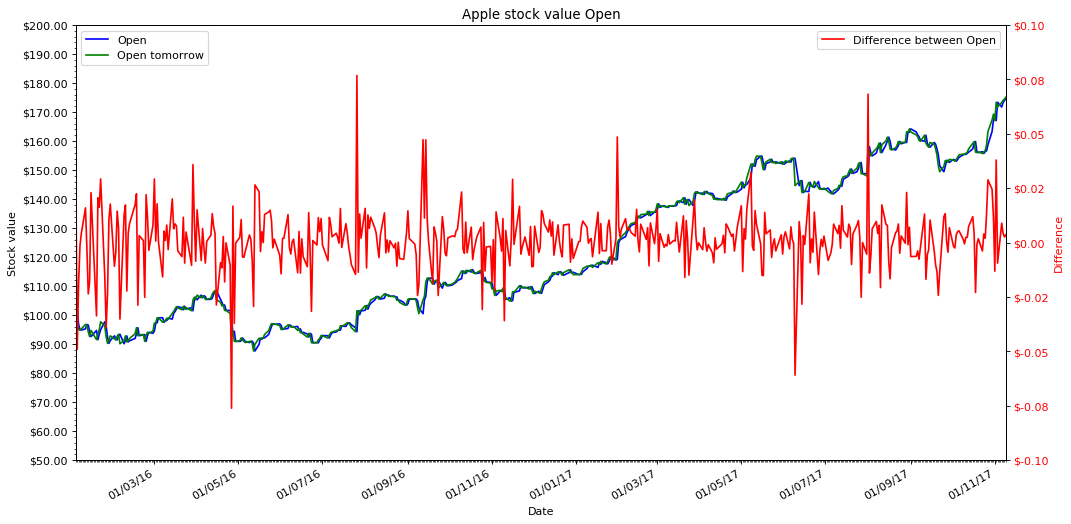

In [359]:

df_comparison = df[df.Date >= '2016-01-04']

y1 = {'series' : ['Open','Tomorrow_Open'],
       'ticker' : {'text':'Stock value',
                   'locator':{
                       'major':10,
                       'minor':2
                   },
                   'limit':{
                      'min':50,
                      'max':200,
                      }
                  },
       'colors': ['blue', 'green'],
       'legends' : ["Open", "Open tomorrow"]
     }

y2 = {'series' : ['Diff_Tomorrow_Open'],
       'ticker' : {'text':'Difference',
                  'color': 'red',
                  'limit':{
                      'min':-0.1,
                      'max':0.1,
                  }},
        'colors': ['red'],
        'legends' : ["Difference between Open"]
     }
x = {'series' : ['Date']}

plot_differences(df_comparison,y1, y2,'Apple stock value Open')

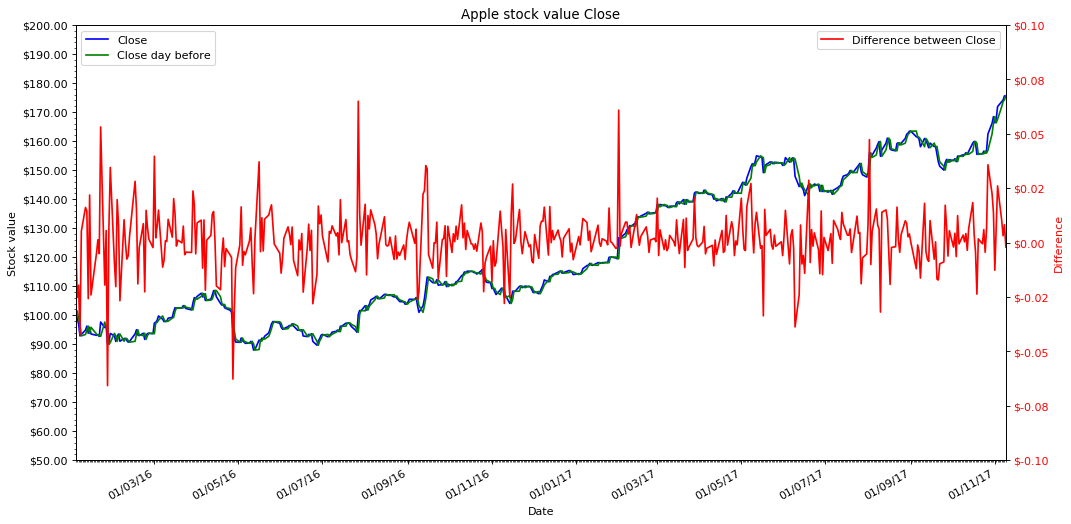

In [360]:
y1 = {'series' : ['Close','Yesterday_Close'],
       'ticker' : {'text':'Stock value',
                   'locator':{
                       'major':10,
                       'minor':2
                   }, 
                   'limit':{
                      'min':50,
                      'max':200,
                      }
                  },
       'colors': ['blue', 'green'],
       'legends' : ["Close", "Close day before"]
     }

y2 = {'series' : ['Diff_Today_Close'],
       'ticker' : {'text':'Difference',
                  'color': 'red',
                  'limit':{
                      'min':-0.1,
                      'max':0.1,
                      }
                  },
        'colors': ['red'],
        'legends' : ["Difference between Close"]
     }
x = {'series' : ['Date']}
plot_differences(df_comparison,y1, y2,'Apple stock value Close')

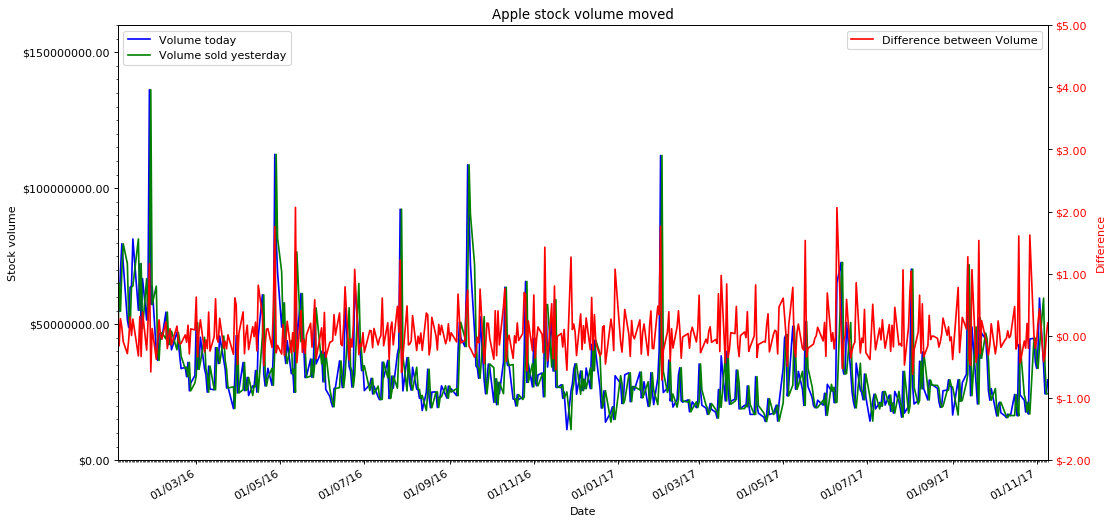

In [361]:
y1 = {'series' : ['Volume','Yesterday_Volume'],
       'ticker' : {'text':'Stock volume',
                   'locator':{
                       'major':5.0E+7,
                       'minor':5.0E+6
                   },
                  'limit':{
                      'min':0,
                      'max':1.6E+8,
                      }
                  },
       'colors': ['blue', 'green'],
       'legends' : ["Volume today", "Volume sold yesterday"]
     }

y2 = {'series' : ['Diff_Today_Volume'],
       'ticker' : {'text':'Difference',
                  'color': 'red',
                  'limit':{
                      'min':-2,
                      'max':5,
                      }
                  },
        'colors': ['red'],
        'legends' : ["Difference between Volume"],
     }
x = {'series' : ['Date']}
plot_differences(df_comparison,y1, y2,'Apple stock volume moved')

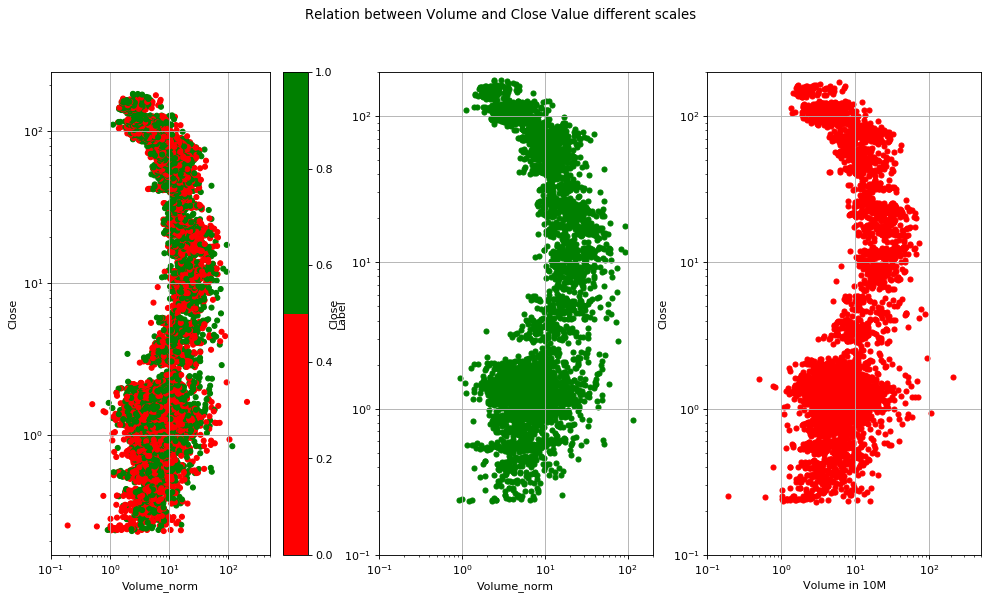

In [450]:
from matplotlib.pyplot import figure
import matplotlib

colors=['red','green']
cmap = matplotlib.colors.ListedColormap(colors)
df = df.assign(Volume_norm=lambda x: x.Volume/10000000)

fig = figure(num=None, figsize=(15, 8), dpi=80, facecolor='w', edgecolor='k')
plt.subplot(131)
ax = plt.gca()
#ax.yaxis.set_major_formatter(formatter)
#ax.yaxis.set_major_locator(MultipleLocator(20))
#ax.yaxis.set_minor_locator(MultipleLocator(10))
df.plot(kind='scatter',y='Close', x='Volume_norm',c='Label', cmap= cmap, ax=ax,title = '')
ax.set_xlim(0.1, 500)
plt.xscale('log')
#ax.set_xlim(0.1, 500)
plt.yscale('log')
plt.grid(True)

plt.subplot(132)
ax = plt.gca()
green=df[df.Label==1]
green.plot(kind='scatter',y='Close', x='Volume_norm',c='green', ax=ax,title = '')
ax.set_xlim(0.1, 200)
plt.xscale('log')
ax.set_ylim(0.1, 200)
plt.yscale('log')
plt.grid(True)

plt.subplot(133)
ax = plt.gca()
red=df[df.Label==0]
red.plot(kind='scatter',y='Close', x='Volume_norm', ax=ax,color='red', title = '')
ax.set_xlabel('Volume in 10M')
plt.xscale('log')
plt.yscale('log')
ax.set_ylim(0.1, 200)
ax.set_xlim(0.1, 500)
plt.grid(True)


fig.suptitle('Relation between Volume and Close Value log scale')
plt.show()    


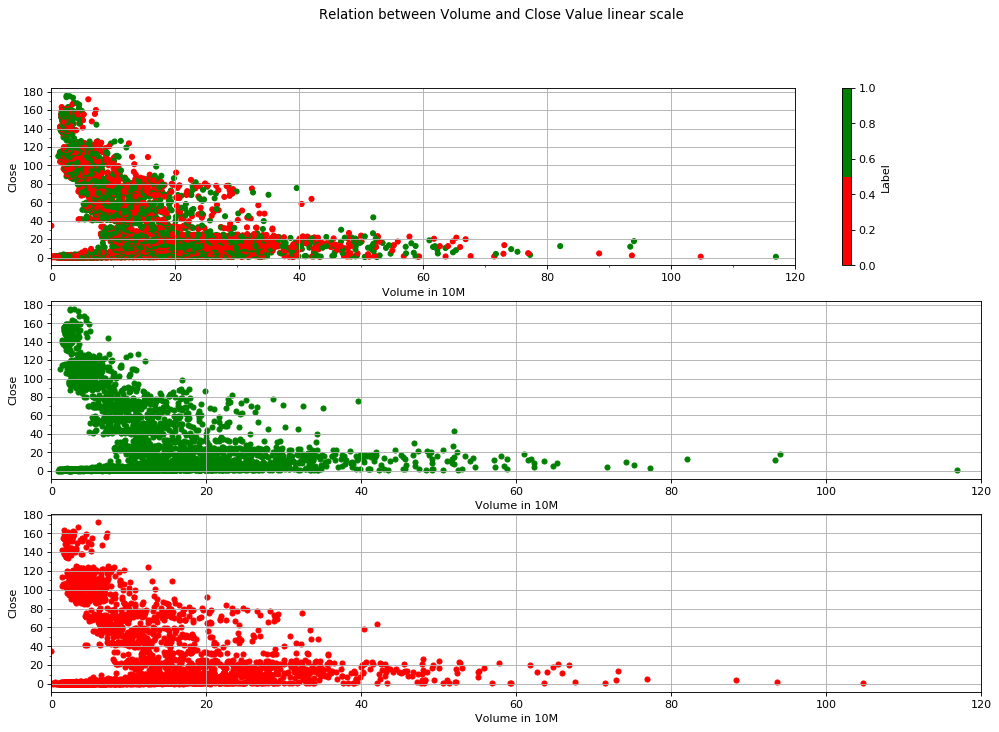

In [460]:
colors=['red','green']
cmap = matplotlib.colors.ListedColormap(colors)
df = df.assign(Volume_norm=lambda x: x.Volume/10000000)

fig = figure(num=None, figsize=(15, 10), dpi=80, facecolor='w', edgecolor='k')
plt.subplot(311)
ax = plt.gca()
ax.yaxis.set_major_locator(MultipleLocator(20))
ax.yaxis.set_minor_locator(MultipleLocator(10))
ax.xaxis.set_major_locator(MultipleLocator(20))
ax.xaxis.set_minor_locator(MultipleLocator(10))
df.plot(kind='scatter',y='Close', x='Volume_norm',c='Label', cmap= cmap, ax=ax,title = '')
ax.set_xlabel('Volume in 10M')
ax.set_xlim(0, 120)
plt.grid(True)

plt.subplot(312)
ax = plt.gca()
green=df[df.Label==1]
green.plot(kind='scatter',y='Close', x='Volume_norm',c='green', ax=ax,title = '')
ax.yaxis.set_major_locator(MultipleLocator(20))
ax.yaxis.set_minor_locator(MultipleLocator(10))
ax.set_xlabel('Volume in 10M')
ax.set_xlim(0, 120)
plt.grid(True)

plt.subplot(313)
ax = plt.gca()
red=df[df.Label==0]
red.plot(kind='scatter',y='Close', x='Volume_norm', ax=ax,color='red', title = '')
ax.set_xlabel('Volume in 10M')
ax.yaxis.set_major_locator(MultipleLocator(20))
ax.yaxis.set_minor_locator(MultipleLocator(10))
ax.set_xlim(0, 120)
plt.grid(True)


fig.suptitle('Relation between Volume and Close Value linear scale')
plt.show() 